In [1]:
from qutip import *
import numpy as np 
import pandas as pd 
import scipy.linalg as LA
np.set_printoptions(precision=2)  #Suppress the SF of print outs
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error, make_scorer, accuracy_score
from tqdm import tqdm
from sklearn.pipeline import Pipeline

# Reservoir Model

We now look to extend what we have done to $1$ interface qubit and $2$ reservoir qubits. We have a choice on how to connect them. Either each reservoir qubit interacts with the interface, or we connect the interface to only one reservoir qubit and allow the excitation to spread within the reservoir. We will investigate both scenarios. 

### Interface Connected to $1$ Reservoir Qubit - Chain Model

In this case, we will need a cascade and damping term for the $I$ qubit and qubit $1$ in reservoir. We will only need a cascade term in qubit $2$? Or Should we make it such that the interface is dissipated and the cascade can oscillate freely between connected reservoir qubits? Try to generalise the code here so it is easily to scale up the dimension of the reservoir. 

Connection between the interface qubit $I$ and each reservoir qubit $j$ the accounts for cascade of excitation from $I$ is given by 

$$\gamma_c\left(\left[\sigma_I^-\rho, \sigma^+_j\right] + \left[\sigma_j^-, \rho\sigma_I^+\right]\right).$$

So for $I$ only connected to $j=1$ we have

$$\gamma_c\left(\left[\sigma_I^-\rho, \sigma^+_1\right] + \left[\sigma_1^-, \rho\sigma_I^+\right]\right).$$

Coherent Schrodinger dynamics within the reservoir are given by 

$$-\frac{i}{\hbar}\left[H_R,\rho\right] \quad \text{where} \quad H_R=\sum_{i,j}J_{i,j}\left(\sigma_i^+\sigma_j^- + \sigma_j^+\sigma_i^-\right)$$

Excitation dissipation is given by the Lindblad operators. We will have only excitation dissipation on the interface as the Schrodinger dynamics within the reservoir should prevent the need for excitation dissipation in the reservoir.

$$\gamma_D\left(2\sigma_I^-\rho\sigma_I^+ - \left\{\sigma^+_I\sigma_I^-, \rho\right\}\right)$$

Hence, overall the dynamics are given by 


$$\partial_t\rho=\gamma_c\left(\left[\sigma_I^-\rho, \sigma^+_1\right] + \left[\sigma_1^-, \rho\sigma_I^+\right]\right) + \gamma_D\left(2\sigma_I^-\rho\sigma_I^+ - \left\{\sigma^+_I\sigma_I^-, \rho\right\}\right) -\frac{i}{\hbar}\left[H_R,\rho\right]$$

Numerical integration given by a 4th order Runge-Kutta method
$$\rho(t+dt) = \rho(t) + \frac{1}{6}\left(k_1 + 2k_2 + 2k_3 + k_4 \right).$$
If we allow 
$$f(\rho)=\gamma_c\left(\left[\sigma_I^-\rho, \sigma^+_1\right] + \left[\sigma_1^-, \rho\sigma_I^+\right]\right) + \gamma_D\left(2\sigma_I^-\rho\sigma_I^+ - \left\{\sigma^+_I\sigma_I^-, \rho\right\}\right) -\frac{i}{\hbar}\left[H_R,\rho\right],$$ 
then the $k$ terms in the expansion above are given by
$$\begin{aligned}
k_1 &= f\left(\rho\right)dt,\\
k_2 &= f\left(\rho+\frac{1}{2}k_1\right)dt,\\
k_3 &= f\left(\rho + \frac{1}{2}k_2\right)dt,\\
k_4 &= f\left(\rho + k_3\right)dt.
\end{aligned}$$

### Interface connected to mulitple reservoir qubits 

In this more general scenario, the evolution of the system will be described by 

$$\partial_t\rho=\sum_{j=1}^N\gamma_j\left(\left[\sigma_I^-\rho, \sigma^+_j\right] + \left[\sigma_j^-, \rho\sigma_I^+\right]\right) + \gamma_D\left(2\sigma_I^-\rho\sigma_I^+ - \left\{\sigma^+_I\sigma_I^-, \rho\right\}\right) -\frac{i}{\hbar}\left[H_R,\rho\right],$$

where $\sigma_j$ refers to the $j^{\text{th}}$ qubit in the reservoir and $\gamma_j$ is a constant measuring the cascade between the interface and reservoir qubit $j$. We are going to time gate the dynamics, by having the initial transfer of excitation via 

$$\partial_t\rho=\sum_{j=1}^N\gamma_j\left(\left[\sigma_I^-\rho, \sigma^+_j\right] + \left[\sigma_j^-, \rho\sigma_I^+\right]\right) + \gamma_D\left(2\sigma_I^-\rho\sigma_I^+ - \left\{\sigma^+_I\sigma_I^-, \rho\right\}\right)$$

and then the internal Hamiltonian dynamics within the reservoir of 

$$\partial_t\rho= -\frac{i}{\hbar}\left[H_R,\rho\right].$$

### Measurement of Excitation

Measurement of the excitation of a qubit is given by a comparison between the groundstate energy and the exctied state energy. Since we have that the groundstate is $|1>$ and the excited state is $|0>$, this means the expectation value of excitation is given by 

$$<0|\rho|0> - <1|\rho|1>,$$

for any time $t$. However, it is clear to see that these two expressions can be given by a trace 

$$\text{Tr}\left(|0><0| \rho\right) - \text{Tr} \left(|1><1| \rho \right).$$

Due to the linearity of the trace, this is just given by 

$$\text{Tr} \left([|0><0| - |1><1|]\rho\right),$$

which simply results in 

$$\text{Tr}\left(\sigma_z\rho\right) = <\sigma_z>.$$

For a given qubit in the reservoir, $\rho$ must correspond to the density matrix with all other qubit components removed via partial trace. 

### Purity

The purity of a normalised quantum state satisfies $$\frac{1}{d}\leq\text{Tr}\left(\rho^2\right)\leq1$$ where $d$ is the dimension of the Hilbert Space.

### Gradient Descent and Linear Entropy

We would like to set the cascade and dissipation parameters such that the purity of the reservoir and interface system is maxmised. We would want to use gradient descent for this, but $\text{Tr}(\rho^2)$ is unbounded due to the non-unitary dynamics. Hence, it cannot be used as a cost function as the maximum of the purity is not $1$. However, we look to linear entropy instead 
$$S_L(\rho)=\frac{N}{N-1}\left[1-\text{Tr}(\rho^2)\right],$$
where $1$ is a maximally mixed state and $0$ is a completely pure state. This initially seems to have the same problem, as the GD algorithm will just make the purity larger and larger to minimise the linear entropy. but if we take the absolute value of the linear entropy then we have;
$$0\leq\left|S_L(\rho)\right|\leq1.$$
Hence, by minimising $\left|S_L(\rho)\right|$ we maximise the purity of the system to $1$.
We choose the purest interface state to perform this optimisation with. Then, we ensure that all other interface states will produce a total purity less than $1$ and the dynamics of the system remain physical.

In [2]:
def initial_rho_1_qubit(interface, reservoir):
    '''Initial density matrix for one reservoir qubit'''
    ket_initial=tensor(Qobj(interface), Qobj(reservoir))
    #Density matrix of the initial system
    rho_initial=ket_initial * ket_initial.dag()
    return rho_initial
    

def initial_rho(interface, reservoir):
    '''Returns the initial density matrix of the system given the interface and qubit states as arrays'''
    placeholder=Qobj(reservoir[0])
    for ii in range(1, len(reservoir)):
        placeholder=tensor(placeholder, Qobj(reservoir[ii])) #Initial state of reservoir
    initial_state=tensor(Qobj(interface), placeholder)
    rho = initial_state * initial_state.dag()
    return rho


def total_rho(interface_rho, reservoir):
    '''Returns the initial density matrix of the total system given the interface as a density matrix'''
    placeholder=Qobj(reservoir[0])
    for ii in range(1, len(reservoir)):
        placeholder=tensor(placeholder, Qobj(reservoir[ii])) #Initial state of reservoir
    rhoR = placeholder*placeholder.dag()
    #Final tensor 
    rho = tensor(Qobj(interface_rho), rhoR)
    return rho
    

def multi_cascade(gamma_vector, rho, interface_vector):
    '''Cascade term from interface to qubit 1'''
    #interface_vector is the length of number of qubits in interface with 0 or 1 as elements 
    #1 indicates cascade from that qubit and 0 indicates disconnection from reservoir 
    if interface_vector[0]==0:
        interface_m = identity(2)
        interface_p = identity(2)
    elif interface_vector[0]==1:
        interface_m = sigmam()
        interface_p = sigmap()
    for ii in range(1,len(interface_vector)):
        if interface_vector[ii]==0:
            interface_m=tensor(interface_m, identity(2))
            interface_p=tensor(interface_p, identity(2))
        elif interface_vector[ii]==1:
            interface_m=tensor(interface_m, sigmam())
            interface_p=tensor(interface_p, sigmap())
    
    #Specify the dimension of the interface
    N_int=len(interface_vector)
    
    #Include a clause for 1 qubit case 
    if len(gamma_vector)==1:
        sigma_I_minus = tensor(interface_m, identity(2))
        sigma_I_plus = tensor(interface_p, identity(2))
        sigma_1_minus = tensor(identity((2**N_int)), sigmam())
        sigma_1_plus = tensor(identity(2**N_int), sigmap())
        cas = gamma_vector[0]*(commutator(Qobj(sigma_I_minus.full())*Qobj(rho.full()), Qobj(sigma_1_plus.full())) + 
                              commutator(Qobj(sigma_1_minus.full()), Qobj(rho.full())*Qobj(sigma_I_plus.full())))

        return cas
    
    else:
        #Generate the needed pauli operators in system size
        sig_I_minus=tensor(interface_m, identity(int(len(rho.full())/(2**N_int)))) #Need to divide 2^N_int to account for dimension 
        sig_I_plus=tensor(interface_p, identity(int(len(rho.full())/(2**N_int))))
        sig_pos_list = np.zeros((len(gamma_vector), 2**(len(gamma_vector)+N_int), 2**(len(gamma_vector)+N_int)), dtype=complex) #Hold all possible operators 
        sig_minus_list = np.zeros((len(gamma_vector), 2**(len(gamma_vector)+N_int), 2**(len(gamma_vector)+N_int)), dtype=complex)

        #Populate the operator list
        sig_pos_list[0]=tensor(identity(2**N_int), tensor(sigmap(), identity(2**(len(gamma_vector)-1))))
        sig_minus_list[0]=tensor(identity(2**N_int), tensor(sigmam(), identity(2**(len(gamma_vector)-1))))
        sig_pos_list[-1] = tensor(identity(2**N_int), tensor(identity(2**(len(gamma_vector)-1)), sigmap()))
        sig_minus_list[-1] = tensor(identity(2**N_int), tensor(identity(2**(len(gamma_vector)-1)), sigmam()))    #Interior terms
        if len(gamma_vector)>2:
            for ii in range(1,len(gamma_vector)-1):
                sig_pos_list[ii] = tensor(identity(2**N_int), tensor(tensor(identity(2**ii), sigmap()), identity(2**(len(gamma_vector)-ii-1))))
                sig_minus_list[ii] = tensor(identity(2**N_int), tensor(tensor(identity(2**ii), sigmam()), identity(2**(len(gamma_vector)-ii-1))))

        #Populate the cascade terms 
        cas=0
        for ii in range(len(gamma_vector)):
            cas += gamma_vector[ii]*(commutator(Qobj(sig_I_minus.full())*Qobj(rho.full()), Qobj(sig_pos_list[ii])) + 
                                     commutator(Qobj(sig_minus_list[ii]), Qobj(rho.full())*Qobj(sig_I_plus.full())))
        return cas


def dissipate(gamma_D, rho, interface_vector):
    '''Dissipation term for the interface qubit'''
    #Generate the interface operators
    if interface_vector[0]==0:
        interface_m = identity(2)
        interface_p = identity(2)
    elif interface_vector[0]==1:
        interface_m = sigmam()
        interface_p = sigmap()
    for ii in range(1,len(interface_vector)):
        if interface_vector[ii]==0:
            interface_m=tensor(interface_m, identity(2))
            interface_p=tensor(interface_p, identity(2))
        elif interface_vector[ii]==1:
            interface_m=tensor(interface_m, sigmam())
            interface_p=tensor(interface_p, sigmap())
    
    #Specify the dimension of the interface
    N_int=len(interface_vector)
    
    #Define the needed Pauli operators 
    sig_I_minus=tensor(interface_m, identity(int(len(rho.full())/(2**N_int))))
    sig_I_plus=tensor(interface_p, identity(int(len(rho.full())/(2**N_int))))
        
    #Use anticommutator for the Lindblad operators 
    diss = gamma_D * (2*Qobj(sig_I_minus.full())*Qobj(rho.full())*Qobj(sig_I_plus.full()) - 
                     commutator(Qobj(sig_I_plus.full())*Qobj(sig_I_minus.full()), Qobj(rho.full()), kind='anti'))
    return diss
    
    
def hamiltonian_R(J_matrix, interface_vector):
    '''Return the Hamiltonian of the reservoir given coupling between spins'''
    H_R=0 #Initialise Hamiltonian
    sig_pos_list = np.zeros((len(J_matrix), 2**(len(J_matrix)), 2**(len(J_matrix))), dtype=complex) #Hold all possible operators 
    sig_minus_list = np.zeros((len(J_matrix), 2**(len(J_matrix)), 2**(len(J_matrix))), dtype=complex)
    
    #Populate the operator list
    sig_pos_list[0]=tensor(sigmap(), identity(2**(len(J_matrix)-1)))
    sig_minus_list[0]=tensor(sigmam(), identity(2**(len(J_matrix)-1)))
    sig_pos_list[-1] = tensor(identity(2**(len(J_matrix)-1)), sigmap())
    sig_minus_list[-1] = tensor(identity(2**(len(J_matrix)-1)), sigmam())    #Interior terms
    if len(J_matrix)>2:
        for ii in range(1,len(J_matrix)-1):
            sig_pos_list[ii] = tensor(tensor(identity(2**ii), sigmap()), identity(2**(len(J_matrix)-ii-1)))
            sig_minus_list[ii] = tensor(tensor(identity(2**ii), sigmam()), identity(2**(len(J_matrix)-ii-1)))
        
    #Find the Hamiltonian
    for ii in range(len(J_matrix)):
        for jj in range(len(J_matrix)):
            operator = (Qobj(sig_pos_list[ii])*Qobj(sig_minus_list[jj]) + Qobj(sig_pos_list[jj])*Qobj(sig_minus_list[ii]))
            H_R += J_matrix[ii,jj] * operator
            
    #Tensor with identity to make the right size of system 
    H_R=tensor(identity(2**len(interface_vector)), Qobj(H_R))        
    H_R=Qobj(H_R.full())
    return H_R


def connect_interface(rho0, times, gamma_C, gamma_D, interface_vector):
    '''Connect the reservoir and the interface to allow transfer of excitation'''
    #Generate tensor to hold rho values in time
    dens_tensor = np.zeros((len(times), len(rho0.full()), len(rho0.full())), 
                           dtype=complex)
    
    #Find the time separation 
    dt=times[1]-times[0]
    #Initialise the first term of the density tensor 
    dens_tensor[0]=rho0
    
    #Evolve using Runge-Kutta O(dt^4) methods
    for ii in range(1,len(times)): #Setting hbar=1
        #Determine Runge-Kutta terms
        k1 = (multi_cascade(gamma_C, Qobj(dens_tensor[ii-1]), interface_vector) + dissipate(gamma_D, Qobj(dens_tensor[ii-1]), interface_vector))*dt
        k2 = (multi_cascade(gamma_C, Qobj(dens_tensor[ii-1] + 0.5*k1), interface_vector) + dissipate(gamma_D, Qobj(dens_tensor[ii-1] + 0.5*k1), interface_vector))*dt
        k3 = (multi_cascade(gamma_C, Qobj(dens_tensor[ii-1] + 0.5*k2), interface_vector) + dissipate(gamma_D, Qobj(dens_tensor[ii-1] + 0.5*k2), interface_vector))*dt
        k4 = (multi_cascade(gamma_C, Qobj(dens_tensor[ii-1] + k3), interface_vector) + dissipate(gamma_D, Qobj(dens_tensor[ii-1] + k3), interface_vector))*dt
        #Solve Taylor Expansion
        dens_tensor[ii] = Qobj(dens_tensor[ii-1] + (1/6)*(k1 + 2*k2 + 2*k3 + k4))
        
    return dens_tensor


def reservoir_dynamics(rho0, times, J_matrix, interface_vector):
    '''Evolve the dynamics inside the reservoir after transfer of excitation'''
    #Generate tensor to hold rho values in time
    dens_tensor = np.zeros((len(times), len(Qobj(rho0).full()), len(Qobj(rho0).full())), 
                           dtype=complex)
    
    #Find the time separation 
    dt=times[1]-times[0]
    #Initialise the first term of the density tensor 
    dens_tensor[0]=rho0
    
    #Evolve using Runge-Kutta O(dt^4) methods
    for ii in range(1,len(times)): #Setting hbar=1
        #Determine the Runge-Kutta terms
        k1 = (-1j * commutator(hamiltonian_R(J_matrix, interface_vector), Qobj(dens_tensor[ii-1]))) * dt
        k2 = (-1j * commutator(hamiltonian_R(J_matrix, interface_vector), Qobj(dens_tensor[ii-1] + 0.5*k1))) * dt
        k3 = (-1j * commutator(hamiltonian_R(J_matrix, interface_vector), Qobj(dens_tensor[ii-1] + 0.5*k2))) * dt
        k4 = (-1j * commutator(hamiltonian_R(J_matrix, interface_vector), Qobj(dens_tensor[ii-1] + k3))) * dt
        #Solve the Taylor Expansion
        dens_tensor[ii] = Qobj(dens_tensor[ii-1] + (1/6)*(k1 + 2*k2 + 2*k3 + k4))
    return dens_tensor


def total_evolution(rho0, times, gamma_C, gamma_D, J_matrix, interface_vector): 
    '''Function to evolve through excitation transfer and reservoir dynamics'''
    #Split the time into two sections and use the first for the connection
    dens_1 = connect_interface(rho0, np.array_split(times,2)[0], gamma_C, gamma_D, interface_vector)
    
    #Use the second time split and the final term from the last tensor to form the dynamics after 
    dens_2 = reservoir_dynamics(dens_1[-1], np.array_split(times, 2)[1], J_matrix, interface_vector)
    
    #Join the two density tensors 
    dens = np.vstack((dens_1, dens_2))
    return dens

    
def trace_and_purity(density_matrices, times):
    '''Plot the trace and purity in one graph in time'''
    #Array of the trace values 
    traces=np.zeros(len(times))
    for ii in range(len(times)):
        traces[ii]=Qobj(density_matrices[ii]).tr()
        
    #Plot the trace of the density matrix squared 
    trace_squared=np.zeros(len(times))
    for ii in range(len(times)):
        trace_squared[ii]=Qobj(density_matrices[ii]@density_matrices[ii]).tr()
        
    fig, (ax1, ax2) = plt.subplots(2, dpi=125, sharex = True, sharey = True, gridspec_kw = {'hspace':0.1})

    #Plot the change in trace values over time
    ax1.plot(times, traces)
    ax1.set(ylabel=r'$Tr(\rho)$')
    
    #Purity plot
    ax2.plot(times, trace_squared)
    ax2.set(xlabel='t', ylabel=r'$Tr(\rho ^2)$')
    
    
#Function to plot how the diagonal elements of the density matrix are changing over time
def inspect_diagonal(density_matrices, times):
    '''Function to plot how the diagonal elements of the 1 reservoir density matrix are changing over time'''
    #Create 4 arrays to track the 4 diagonal elements 
    a11=np.zeros(len(times), dtype=complex)
    a22=np.zeros(len(times), dtype=complex)
    a33=np.zeros(len(times), dtype=complex)
    a44=np.zeros(len(times), dtype=complex)
    
    for ii in range(len(times)):
        a11[ii]=np.real(density_matrices[ii,0,0])
        a22[ii]=np.real(density_matrices[ii,1,1])
        a33[ii]=np.real(density_matrices[ii,2,2])
        a44[ii]=np.real(density_matrices[ii,3,3])
        
    #Plot the elements against time
    plt.figure(dpi=125)
    plt.plot(times, a11, label=r'$\rho_{11}$')
    plt.plot(times, a22, label=r'$\rho_{22}$')
    plt.plot(times, a33, '--',label=r'$\rho_{33}$')
    plt.plot(times, a44, label=r'$\rho_{44}$')
    plt.legend()
    
    
def reduced_density_matrix_a(rho, qubits):
    '''Given a density matrix of composite Hilbert space NaxNb, 
    this will return the reduced density matrix of space Na via partial trace'''
    #Dimension of the system wanted
    Na = 2**(qubits)
    #Dimension of the rest of the system 
    Nb = int(len(rho)/Na)
    #Recast the density matrix into a tensor
    rho_tensor = rho.reshape([Na, Nb, Na, Nb])
    #Contraction over axis 1,3 to produce rho_a
    rho_a = np.trace(rho_tensor, axis1=1, axis2=3)
    return rho_a


def reduced_density_matrix_b(rho, qubits):
    '''Given a density matrix of composite Hilbert space NaxNb, 
    this will return the reduced density matrix of space Nb via partial trace'''
    #Dimension of the system wanted
    Nb = 2**(qubits)
    #Dimension of the rest of the system 
    Na = int(len(rho)/Nb)
    #Recast the density matrix into a tensor
    rho_tensor = rho.reshape([Na, Nb, Na, Nb])
    #Contraction over axis 1,3 to produce rho_a
    rho_b = np.trace(rho_tensor, axis1=0, axis2=2)
    return rho_b


def sig_z_exp(rho, qubit):
    '''Give the expectation value of sigma z for a given qubit given the density matrix of the overall system'''
    #Interface term, unlikely to be needed
    if qubit==1:
        rho = reduced_density_matrix_a(rho, qubit)
    elif qubit == int(len(rho)):
        rho = reduced_density_matrix_b(rho, 1)
    else:
        #Trace out all up to the qubit wanted and then trace out all but the last qubit 
        rho = reduced_density_matrix_b(reduced_density_matrix_a(rho, qubit), 1)
    exp = (sigmaz() * Qobj(rho)).tr()
    return exp


def generate_purestate(N):
    '''Returns an NxN density matrix for a random pure state'''
    #Generate a random complex 2D vector - ensure elements can be negative
    p = Qobj(np.random.uniform(low=-1, high=1, size=N) + 1j*np.random.uniform(low=-1, high=1, size=N))
    #Normalise the ket
    p = p.unit()
    #Generate the density matrix
    P_dens = p * p.dag()
    return P_dens


def generate_mixedstate(N):
    '''Returns an NxN density matrix for a random mixed state'''
    #Generate random complex NxN matrix
    m = Qobj(np.random.uniform(low=-1, high=1, size=(N,N)) + 1j*np.random.uniform(low=0, high=1, size=(N,N)))
    #Normalise 
    M_dens = m * m.dag() / (m * m.dag()).tr()
    return M_dens


def ptb(rho):
    '''Return the partial transpose about subsystem B for a 4x4 density matrix'''
    rho[0:2,0:2] = np.transpose(rho[0:2,0:2])
    rho[0:2,2:4] = np.transpose(rho[0:2,2:4])
    rho[2:4,0:2] = np.transpose(rho[2:4,0:2])
    rho[2:4,2:4] = np.transpose(rho[2:4,2:4])
    return rho


def gen_entangled():
    '''Return a 4x4 density matrix of an entangled sysytem'''
    #Wrap in a while loop to ensure that we get a negative eigenvalue 
    eigenvalues = np.zeros(4)
    while min(eigenvalues)>=0:
        #Generate random complex NxN matrix
        m = Qobj(np.random.uniform(low=-1, high=1, size=(4,4)) + 1j*np.random.uniform(low=-1, high=1, size=(4,4)))
        #Normalise 
        M_dens = (m * m.dag()) / ((m * m.dag()).tr())
        #Find the partial transpose
        pt = ptb(M_dens.full())
        #Find the eigenvalues of the partial transpose 
        eigenvalues = np.real(LA.eigvals(pt))
    return M_dens, linear_entropy(M_dens)
  

def gen_separable():
    '''Return a 4x4 density matrix of a separable system'''
    #Generate random complex NxN matrix
    m = Qobj(np.random.uniform(low=-1, high=1, size=(4,4)) + 1j*np.random.uniform(low=-1, high=1, size=(4,4)))
    #Normalise 
    M_dens = (m * m.dag()) / ((m * m.dag()).tr())
    #Find the partial transpose
    pt = ptb(M_dens.full())
    #Find the eigenvalues of the partial transpose 
    eigenvalues = np.real(LA.eigvals(pt))
    
    #Enforce that the eigenvalues of the partial transpose matrix must be greater than 0
    while min(eigenvalues)<=0:
        p = np.random.uniform(0,1)
        M_dens = p*M_dens + (1-p)*0.25*identity(4)
        #Find the partial transpose
        pt = ptb(M_dens.full())
        #Find the eigenvalues of the partial transpose 
        eigenvalues = np.real(LA.eigvals(pt))
       
    #Now have the function return the linear entropy as the measure 
    return M_dens, linear_entropy(M_dens)


def tr2(rho):
    '''Return the trace of rho^2'''
    rho=Qobj(rho)
    tr2=(rho*rho.dag()).tr()
    return tr2


def linear_entropy(rho):
    '''Calculate the linear entropy of the given denisty matrix'''
    N=len(rho.full())
    le=(N/(N-1))*(1-tr2(rho))
    return le

# def configure_reservoir(rho, cascade_array, dissipation_array,):
#     '''Given information about the interface and reservoir, will configure to the 
#     best settings for cascade and dissipation between both by maximising purity via 
#     gradient descent'''
    

# 2 Qubit Entangled Interface

Now that we have functional code for the $1$ qubit interface that can determine if the input state was mixed or pure with high accuracy via a random forest regressor, we now turn to using an interface of $2$ qubits which are entangled. To generate the training and testing data for this, let us consider $\rho_I$ - the density matrix representing the interface. For the $2$ qubit interface case, $\rho_I$ will be an $8\times8$ matrix. We can interface this directly, or feed in the information about each qubit in the interface sequentually using the reduced density matrix. We will initially opt for the latter, to reduce computational costs. But, we may return to the former in the future to investigate if it offers an advantage. 
To generate each $\rho_I$, we will use a random number generator. 

1) Generate random $\rho_I$

2) Check if $\rho_I$ is entangled. If not, use it as separable data, if yes use it as entangled data.

3) If $\rho_I$ was entangled, generate a separable datapoint with $\rho^{'}_I = p \rho_I + (1-p)\frac{\mathbf{1}}{4}.$ Check that this returns a separable state for the chosen $p$.

There is some subtley here. We must determine the range of tolerance for a state to be considered entangled. This method above may also result in skewed data. A sampling method may need to be used to ensure there are equal entangled and separable datapoints to train and test from to ensure the performance of the algorithm.  

We will need to include a metric for testing if the state in question is entangled. This will be the negativity of partial transposition for us. Recall that this means if after partial transposition our density operartor of bipartition $A$ and $B$ has at least one negative eigenvalue, then the bipartition across $A$ and $B$ must be entangled. Qutip has a native function for returning the partial transpose of a density matrix 

In [6]:
#Generate the training data 
#Number of datapoints 
N = 1200
data = np.zeros((N, 4, 4), dtype=complex)
labels = np.zeros(N, dtype=float)

#Generate the data 
#Use the minimum eigenvalue as a measure of entanglement 
for ii in range(int(N/2)):
    data[ii], labels[ii] = gen_separable()
for ii in range(int(N/2), N):
    data[ii], labels[ii] = gen_entangled()

Make sure the reservoir is obeying purity requirements 

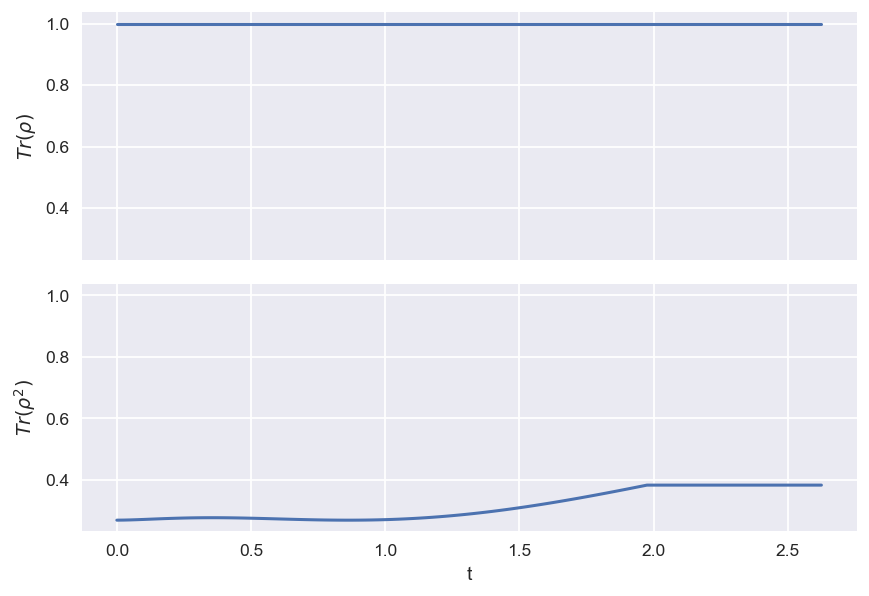

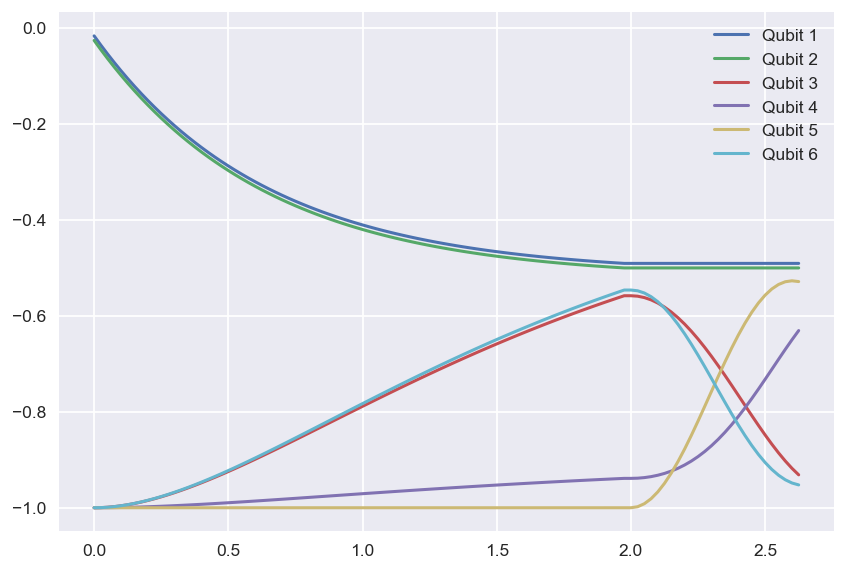

In [93]:
#Choose a 4 qubit reservoir for training 
gamma_C = np.random.uniform(0,1,size=4)
gamma_D = 0.35*np.sum(gamma_C)
J_matrix = np.array([[0,1,0,0],
                     [1,0,1,0],
                     [0,1,0,1],
                     [0,0,1,0]])  #All qubits interconnected

#Timing
dt=0.025
times_interface=np.arange(0,2,dt)
times_hamiltonian = np.arange(2, 2.65, dt) #Cut-off in the peak of oscillation
times_total = np.concatenate((times_interface, times_hamiltonian))

#Reservoir always intially in the groundstate 
reservoir = np.array([[0,1],[0,1],[0,1],[0,1]])

#Test interface
interface = gen_separable()[0]
rho0 = total_rho(interface, reservoir)
tensor1=connect_interface(rho0,
                         times_interface, 
                         gamma_C,
                         gamma_D,
                         [1,1])
tensorhamiltonian=reservoir_dynamics(Qobj(tensor1[-1]), 
                                    times_hamiltonian,
                                    J_matrix,
                                    [1,1])
total_tensor=np.vstack((tensor1, tensorhamiltonian))
trace_and_purity(total_tensor, times_total)

plt.figure(dpi=125)
for jj in range(1,7):
    excitations=np.zeros(len(times_total))
    for ii in range(len(times_total)):
        excitations[ii]=sig_z_exp(total_tensor[ii], jj)
    #Plot 
    plt.plot(times_total, excitations, label='Qubit %s'%jj)
plt.legend()

### Run through the reservoir 

In [94]:
#Choose a 4 qubit reservoir for training 
gamma_C = np.random.uniform(0,1,size=4)
gamma_D = 0.35*np.sum(gamma_C)
J_matrix = np.array([[0,1,0,0],
                     [1,0,1,0],
                     [0,1,0,1],
                     [0,0,1,0]])  #All qubits interconnected

#Timing
dt=0.025
times_interface=np.arange(0,2,dt)
times_hamiltonian = np.arange(2, 2.75, dt) #Cut-off in the peak of oscillation
times_total = np.concatenate((times_interface, times_hamiltonian))

#Reservoir always intially in the groundstate 
reservoir = np.array([[0,1],[0,1],[0,1],[0,1]])

#Tensor to hold the exciations of each qubit for each iteration of training
excitations = np.zeros((N, len(reservoir)))

#Keep track of the purity 
purity = np.zeros((N,len(times_total)))

#Generate the data 
for ii in tqdm(range(N)):
    rho0=total_rho(data[ii], reservoir)
    tensor_cascade=connect_interface(rho0,
                                    times_interface,
                                    gamma_C,
                                    gamma_D,
                                    [1,1])
    #Allow reservoir dynamics 
    tensor_hamiltonian=reservoir_dynamics(Qobj(tensor_cascade[-1]), 
                                            times_hamiltonian, 
                                            J_matrix, 
                                            [1,1])

    # #Total tensor 
    # total_tensor=np.vstack((tensor_cascade, tensor_hamiltonian))
    # #Measure the purity for each run
    # for jj in range(len(times_total)):
    #     purity[ii][jj]=(Qobj(total_tensor[jj])*Qobj(total_tensor[jj])).tr()
    # plt.plot(times_total, purity[ii][:])
    #Measure the excitation of each qubit at the final time of evolution 
    for jj in range(len(reservoir)):
        #Make sure to account for only measuring the reservoir qubits
        #Need jj+3 as we have 2 interface qubits and jj starts at 0
        excitations[ii,jj]=sig_z_exp(tensor_hamiltonian[-1], (jj+3))

100%|██████████| 100/100 [24:27<00:00, 14.68s/it]


Text(0, 0.5, '$<\\sigma^z>$')

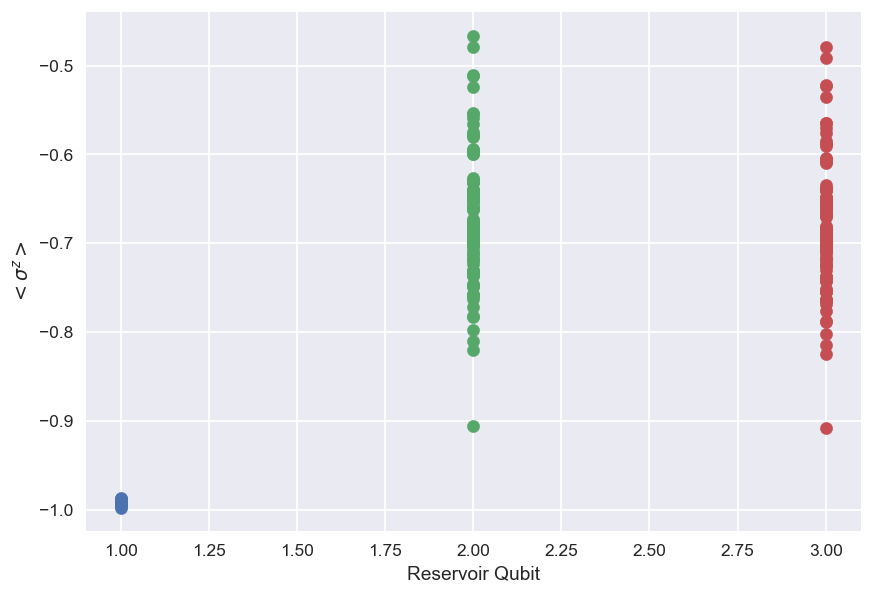

In [95]:
plt.figure(dpi=125)
plt.scatter(np.full(N, 1), excitations[:,0])
plt.scatter(np.full(N, 2), excitations[:,1])
plt.scatter(np.full(N, 3), excitations[:,2])
plt.xlabel('Reservoir Qubit')
plt.ylabel(r'$<\sigma^z>$')

In [96]:
#Save as a dataframe
excitations_df = pd.DataFrame(excitations, columns=['RQubit1', 'RQubit2', 'RQubit3','RQubit4'])
#Export to CSV
excitations_df.to_csv('2QubitEntangled.csv', index=False)

In [97]:
#Read the data back in 
excitations_df = pd.read_csv('2QubitEntangledLinearEntropy.csv')
excitations_df.head(10)

,RQubit1,RQubit2,RQubit3,RQubit4
0,-0.993494,-0.731497,-0.737836,-0.985975
1,-0.990303,-0.599849,-0.609296,-0.979098
2,-0.992731,-0.700011,-0.707093,-0.984330
3,-0.992370,-0.685149,-0.692582,-0.983554
4,-0.991393,-0.644829,-0.653214,-0.981448
5,-0.994454,-0.771149,-0.776551,-0.988046
6,-0.992440,-0.688003,-0.695368,-0.983703
7,-0.993620,-0.736718,-0.742934,-0.986248
8,-0.992514,-0.691092,-0.698385,-0.983864
9,-0.991072,-0.631562,-0.640260,-0.980755


# Julia

# Larger Entanglement Dataset

Combine the 4000 and 500 datasets that we have

In [7]:
df_4000=pd.read_csv("4000_Julia_excitations.csv")
df_500=pd.read_csv("500_Julia_excitations.csv")
#Make total dataframe 
df=df_4000.append(df_500, ignore_index=True, sort=False)

In [8]:
df.head(10)

,Negativity_Eigenvalue,Linear_Entropy,RQubit1,RQubit2,RQubit3,RQubit4
0,0.120671,0.955495,-0.937026,-0.780571,-0.711988,-0.973104
1,0.016309,0.792783,-0.890982,-0.620135,-0.501407,-0.953439
2,0.234199,0.999252,-0.907415,-0.677393,-0.576561,-0.960458
3,0.181192,0.987992,-0.910775,-0.689101,-0.591928,-0.961893
4,0.100076,0.911859,-0.917617,-0.712943,-0.623223,-0.964815
5,0.008502,0.836550,-0.925227,-0.739459,-0.658025,-0.968065
6,0.169340,0.971103,-0.910701,-0.688843,-0.591590,-0.961861
7,0.010192,0.642145,-0.899325,-0.649205,-0.539563,-0.957003
8,0.030624,0.699029,-0.985303,-0.948790,-0.932784,-0.993723
9,0.035262,0.863019,-0.859525,-0.510526,-0.357538,-0.940004


In [12]:
print(len(df))

4500


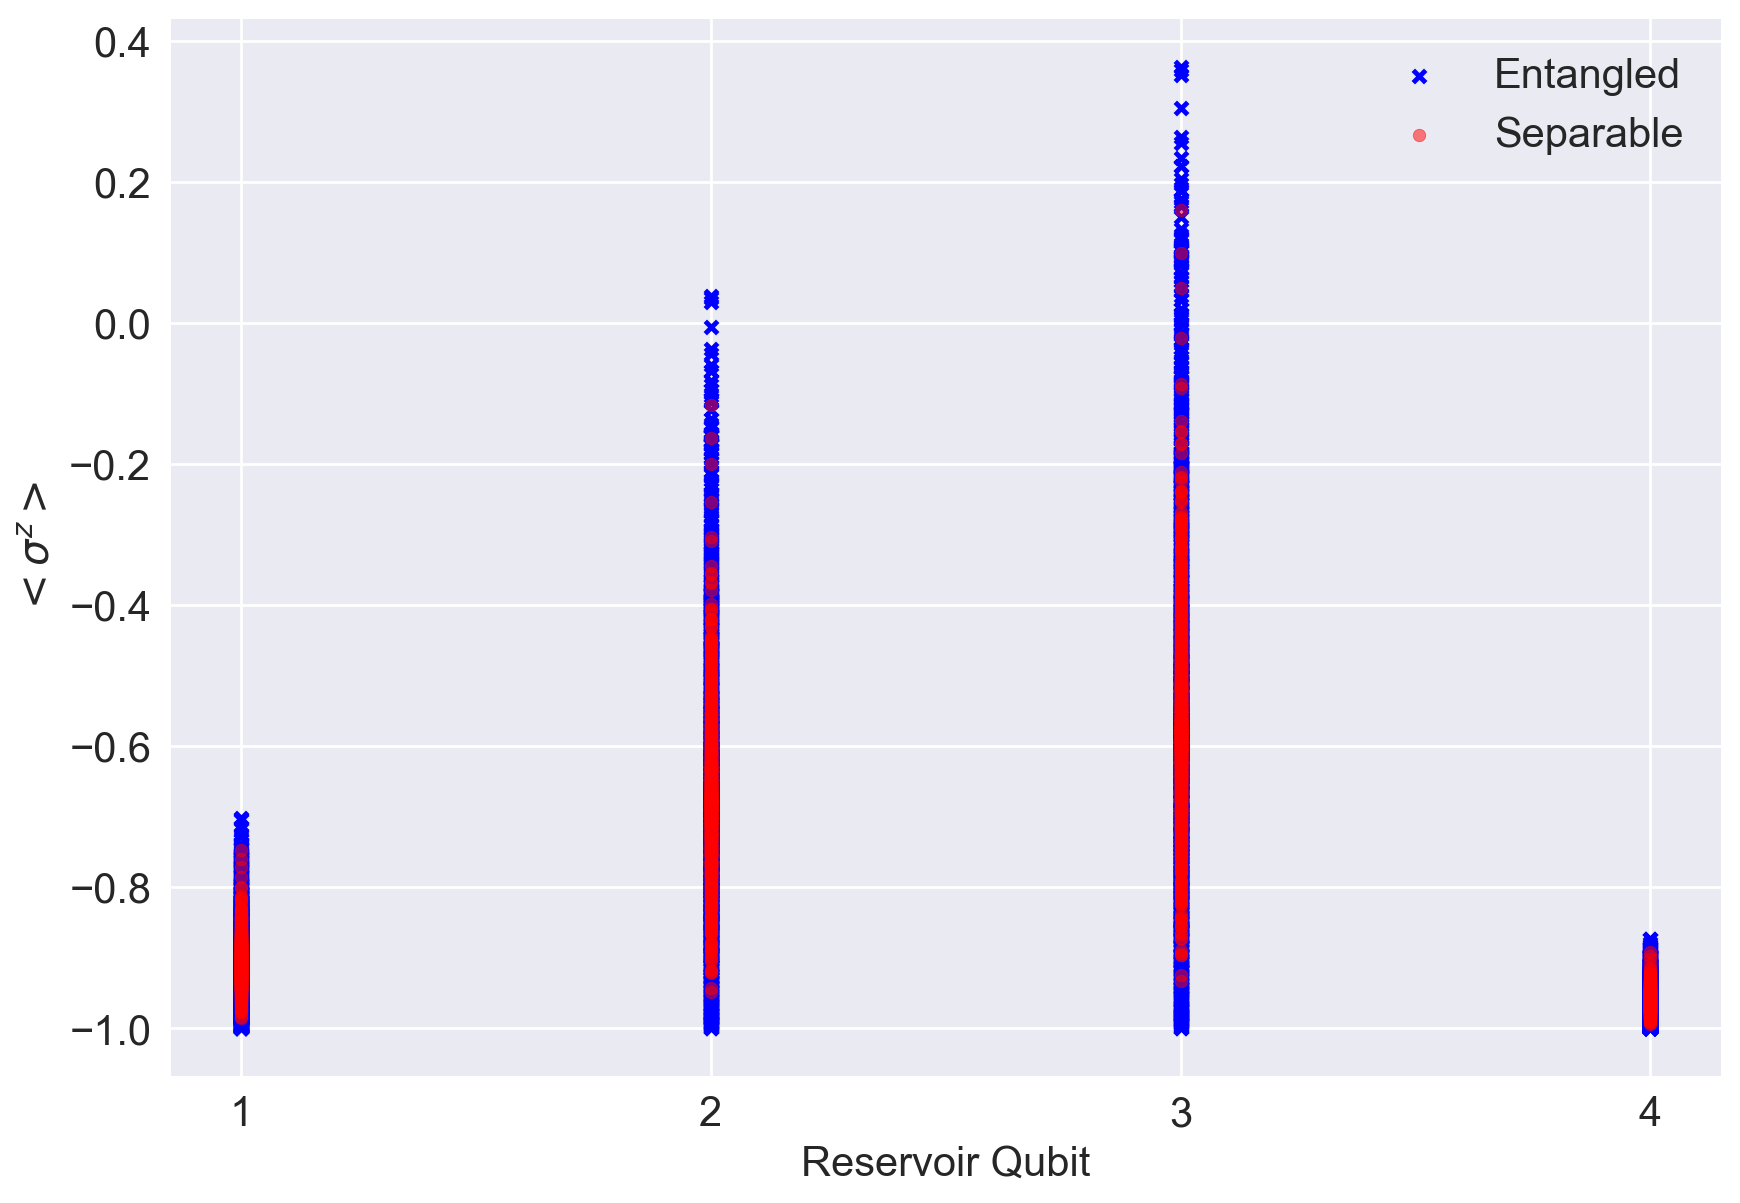

In [20]:
plt.figure(figsize=(10,7), dpi=200)


plt.scatter(np.full(int(4500/2), 1), df['RQubit1'].iloc[int(4500/2): 4500], s=20, marker='x', label='Entangled', c='blue', alpha=1)
plt.scatter(np.full(int(4500/2), 2), df['RQubit2'].iloc[int(4500/2): 4500], s=20, marker='x', c='blue', alpha=1)
plt.scatter(np.full(int(4500/2), 3), df['RQubit3'].iloc[int(4500/2): 4500], s=20, marker='x', c='blue', alpha=1)
plt.scatter(np.full(int(4500/2), 4), df['RQubit4'].iloc[int(4500/2): 4500], s=20, marker='x', c='blue', alpha=1)

plt.scatter(np.full(int(4500/2), 1), df['RQubit1'].iloc[0: int(4500/2)], s=20, marker='o', label='Separable', c='red', alpha=0.5)
plt.scatter(np.full(int(4500/2), 2), df['RQubit2'].iloc[0: int(4500/2)], s=20, marker='o', c='red', alpha=0.5)
plt.scatter(np.full(int(4500/2), 3), df['RQubit3'].iloc[0: int(4500/2)], s=20, marker='o', c='red', alpha=0.5)
plt.scatter(np.full(int(4500/2), 4), df['RQubit4'].iloc[0: int(4500/2)], s=20, marker='o', c='red', alpha=0.5)

plt.xlabel('Reservoir Qubit', fontsize=15)
plt.ylabel(r'$<\sigma^z>$', fontsize=15)
plt.xticks([1,2,3, 4], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

In [7]:
x_train, x_test, y_train, y_test=train_test_split(df[['RQubit1', 'RQubit2', 'RQubit3', 'RQubit4']], 
                                                 df[['Negativity_Eigenvalue', 'Linear_Entropy']],
                                                 test_size=0.3)

In [63]:
rfc_4000=RandomForestRegressor()
rfc_4000.fit(x_train, y_train)

RandomForestRegressor()

In [64]:
predictions=rfc_4000.predict(x_test)

In [65]:
print('Mean Squared Error of RFC Model:\n %s' % mean_squared_error(y_test, predictions))
print('\n Explained Variance Score for RFC Model \n %s' % explained_variance_score(y_test, predictions))

Mean Squared Error of RFC Model:
 0.07921677314082759

 Explained Variance Score for RFC Model 
 0.11196229191308721


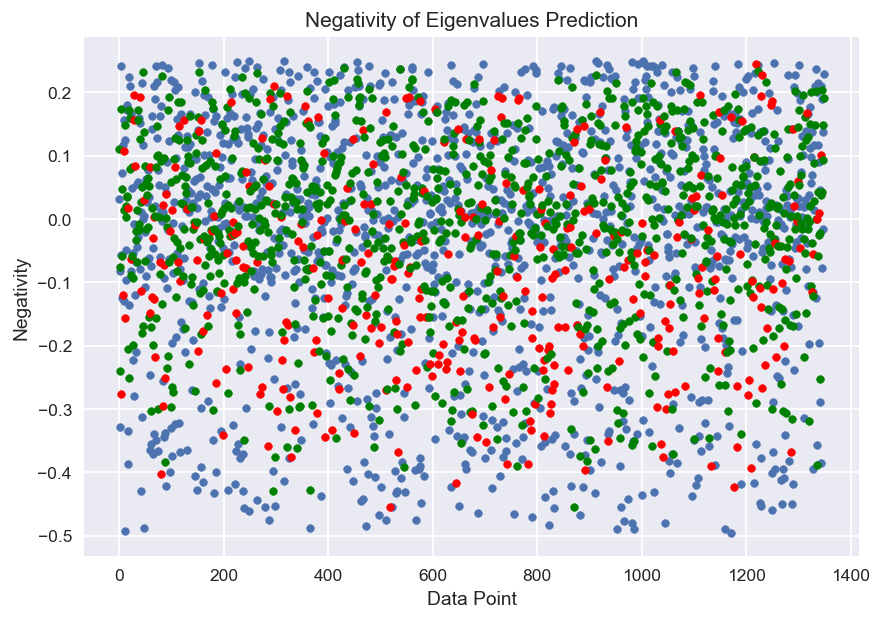

In [66]:
marker_size=20
data_points=np.arange(len(y_test))
plt.figure(dpi=125)
plt.xlabel('Data Point')
plt.ylabel('Negativity')
plt.title('Negativity of Eigenvalues Prediction')
plt.scatter(data_points, y_test["Negativity_Eigenvalue"], label='Test Data', s=marker_size)
for ii in range(len(data_points)):
    #Check the distance of the prediction points and data
    if np.absolute(predictions[ii][0]-np.array(y_test["Negativity_Eigenvalue"])[ii])<0.2:
        plt.scatter(data_points[ii], predictions[ii][0], c='green', s=marker_size)
    elif np.absolute(predictions[ii][0]-np.array(y_test["Negativity_Eigenvalue"])[ii])>0.2:
        plt.scatter(data_points[ii], predictions[ii][0], c='red', s=marker_size)

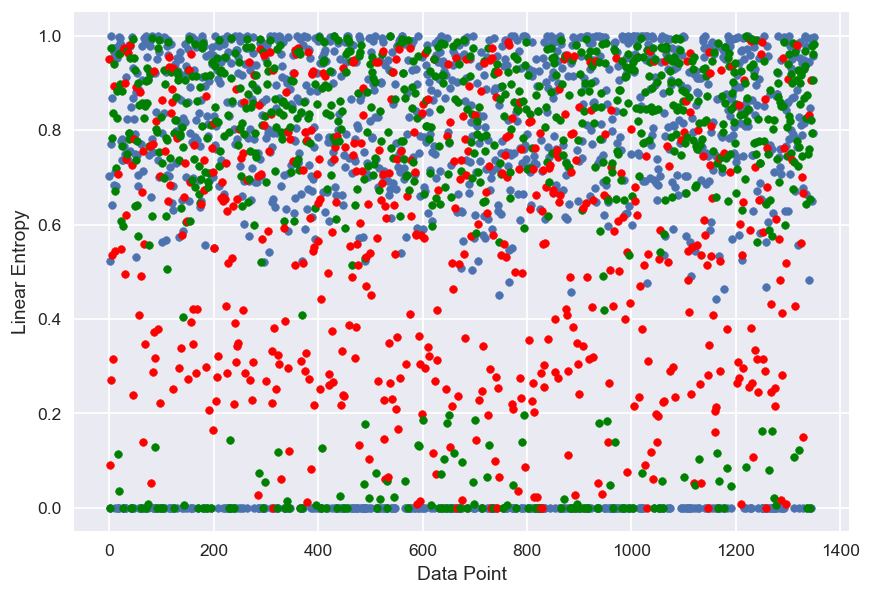

In [67]:
marker_size=20
data_points=np.arange(len(y_test))
plt.figure(dpi=125)
plt.xlabel('Data Point')
plt.ylabel('Linear Entropy')
plt.scatter(data_points, y_test["Linear_Entropy"], label='Test Data', s=marker_size)
for ii in range(len(data_points)):
    #Check the distance of the prediction points and data
    if np.absolute(predictions[ii][1]-np.array(y_test["Linear_Entropy"])[ii])<0.2:
        plt.scatter(data_points[ii], predictions[ii][1], c='green', s=marker_size)
    elif np.absolute(predictions[ii][1]-np.array(y_test["Linear_Entropy"])[ii])>0.2:
        plt.scatter(data_points[ii], predictions[ii][1], c='red', s=marker_size)

In [8]:
N_regressors=10
#Create a range for the regressors
estimators=np.linspace(50,500,N_regressors)
predictions=np.zeros((N_regressors, len(y_test),2))
avg_predictions=np.zeros((len(y_test),2))
for ii in range(N_regressors):
    rfc=RandomForestRegressor(n_estimators=int(estimators[ii]))
    rfc.fit(x_train, y_train)
    predictions[ii]=rfc.predict(x_test)
for ii in range(N_regressors):
    #Take an average 
    avg_predictions+=predictions[ii]
#Normalise 
avg_predictions/=N_regressors

In [9]:
print('Mean Squared Error of RFC Model:\n %s' % mean_squared_error(y_test, avg_predictions))
print('\n Explained Variance Score for RFC Model \n %s' % explained_variance_score(y_test, avg_predictions))

Mean Squared Error of RFC Model:
 0.08097160899389635

 Explained Variance Score for RFC Model 
 0.10725907215237462


# Reservoir Size vs Accuracy 

Here, make sure to average over mutliple RFC models 

## 2 Qubit

In [143]:
df2=pd.read_csv("Reservoir2.csv")
x_train2, x_test2, y_train2, y_test2=train_test_split(df2[['RQubit1', 'RQubit2']], 
                                                 df2[['Negativity_Eigenvalue', 'Linear_Entropy']],
                                                 test_size=0.2)

In [144]:
N_regressors=10
#Create a range for the regressors
estimators=np.linspace(50,500,N_regressors)
predictions2=np.zeros((N_regressors, len(y_test2),2))
avg_predictions2=np.zeros((len(y_test2),2))
for ii in range(N_regressors):
    rfc2=RandomForestRegressor(n_estimators=int(estimators[ii]))
    rfc2.fit(x_train2, y_train2)
    predictions2[ii]=rfc2.predict(x_test2)
for ii in range(N_regressors):
    #Take an average 
    avg_predictions2+=predictions2[ii]
#Normalise 
avg_predictions2/=N_regressors

In [145]:
mse2=mean_squared_error(y_test2, avg_predictions2)
ev2=explained_variance_score(y_test2, avg_predictions2)

print('Mean Squared Error of RFC Model:\n %s' % mse2)
print('\n Explained Variance Score for RFC Model \n %s' % ev2)

Mean Squared Error of RFC Model:
 0.09677990306943737

 Explained Variance Score for RFC Model 
 -0.07820453589017029


## 3 Qubit

In [125]:
df3=pd.read_csv("Reservoir3.csv")
x_train3, x_test3, y_train3, y_test3=train_test_split(df3[['RQubit1', 'RQubit2', 'RQubit3']], 
                                                 df3[['Negativity_Eigenvalue', 'Linear_Entropy']],
                                                 test_size=0.2)

In [126]:
N_regressors=10
#Create a range for the regressors
estimators=np.linspace(50,500,N_regressors)
predictions3=np.zeros((N_regressors, len(y_test3),2))
avg_predictions3=np.zeros((len(y_test3),2))
for ii in range(N_regressors):
    rfc3=RandomForestRegressor(n_estimators=int(estimators[ii]))
    rfc3.fit(x_train3, y_train3)
    predictions3[ii]=rfc3.predict(x_test3)
for ii in range(N_regressors):
    #Take an average 
    avg_predictions3+=predictions3[ii]
#Normalise 
avg_predictions3/=N_regressors

In [127]:
mse3=mean_squared_error(y_test3, avg_predictions3)
ev3=explained_variance_score(y_test3, avg_predictions3)

print('Mean Squared Error of RFC Model:\n %s' % mse3)
print('\n Explained Variance Score for RFC Model \n %s' % ev3)

Mean Squared Error of RFC Model:
 0.09425434850887102

 Explained Variance Score for RFC Model 
 0.015035497025599198


## 4 Qubit

In [128]:
df4=pd.read_csv("Reservoir4.csv")
x_train4, x_test4, y_train4, y_test4=train_test_split(df4[['RQubit1', 'RQubit2', 'RQubit3', 'RQubit4']], 
                                                 df4[['Negativity_Eigenvalue', 'Linear_Entropy']],
                                                 test_size=0.2)

In [129]:
N_regressors=10
#Create a range for the regressors
estimators=np.linspace(50,500,N_regressors)
predictions4=np.zeros((N_regressors, len(y_test4),2))
avg_predictions4=np.zeros((len(y_test4),2))
for ii in range(N_regressors):
    rfc4=RandomForestRegressor(n_estimators=int(estimators[ii]))
    rfc4.fit(x_train4, y_train4)
    predictions4[ii]=rfc4.predict(x_test4)
for ii in range(N_regressors):
    #Take an average 
    avg_predictions4+=predictions4[ii]
#Normalise 
avg_predictions4/=N_regressors

In [130]:
mse4=mean_squared_error(y_test4, avg_predictions4)
ev4=explained_variance_score(y_test4, avg_predictions4)

print('Mean Squared Error of RFC Model:\n %s' % mse4)
print('\n Explained Variance Score for RFC Model \n %s' % ev4)

Mean Squared Error of RFC Model:
 0.06866752350173856

 Explained Variance Score for RFC Model 
 0.16007471045904403


## 5 Qubit

In [131]:
df5=pd.read_csv("Reservoir5.csv")
x_train5, x_test5, y_train5, y_test5=train_test_split(df5[['RQubit1', 'RQubit2', 'RQubit3', 'RQubit4', 'RQubit5']], 
                                                 df5[['Negativity_Eigenvalue', 'Linear_Entropy']],
                                                 test_size=0.2)

In [132]:
N_regressors=10
#Create a range for the regressors
estimators=np.linspace(50,500,N_regressors)
predictions5=np.zeros((N_regressors, len(y_test5),2))
avg_predictions5=np.zeros((len(y_test5),2))
for ii in range(N_regressors):
    rfc5=RandomForestRegressor(n_estimators=int(estimators[ii]))
    rfc5.fit(x_train5, y_train5)
    predictions5[ii]=rfc5.predict(x_test5)
for ii in range(N_regressors):
    #Take an average 
    avg_predictions5+=predictions5[ii]
#Normalise 
avg_predictions5/=N_regressors

In [133]:
mse5=mean_squared_error(y_test5, avg_predictions5)
ev5=explained_variance_score(y_test5, avg_predictions5)

print('Mean Squared Error of RFC Model:\n %s' % mse5)
print('\n Explained Variance Score for RFC Model \n %s' % ev5)

Mean Squared Error of RFC Model:
 0.05600704520618612

 Explained Variance Score for RFC Model 
 0.3604328243928513


## Plotting

In [147]:
mses=np.array([mse2,mse3,mse4,mse5])
evs=np.array([ev2,ev3,ev4,ev5])
rsize=np.array([2,3,4,5])

In [ ]:
plt.figure(figsize=(10,7),dpi=200)
plt.scatter(rsize,mses, color='black', marker='x')
plt.scatter(rsize, evs,  color='black', marker='x') 
plt.plot(rsize,mses,label='Mean Squared Error', color='red')
plt.plot(rsize, evs, label='Explained Variance', color='blue') 
plt.xlabel("Qubits in Reservoir", fontsize=14)
plt.ylabel("Accuracy Metric", fontsize=14)
plt.xticks([2,3,4,5])
plt.legend(fontsize=14)
plt.title('Accuracy vs Reservoir Size for 400 Training and 100 Test States', fontsize=14)



